# Generating Synthetic Time Series Using Randomized Cloud Fields
This file demonstrates code available in `solarspatialtools.synthirrad.cloudfield`, which implements methods described by Lave et al. [1] for generation of synthetic cloud fields that can be used to simulate high frequency solar irradiance data. Some aspects of the implementation diverge slightly from the initial paper to follow a subsequent code implementation of the method shared by the original authors.  

[1] Matthew Lave, Matthew J. Reno, Robert J. Broderick, "Creation and Value of Synthetic High-Frequency Solar Inputs for Distribution System QSTS Simulations," 2017 IEEE 44th Photovoltaic Specialist Conference (PVSC), Washington, DC, USA, 2017, pp. 3031-3033, doi: https://dx.doi.org/10.1109/PVSC.2017.8366378.

# Setup

In [1]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL.ImageColor import colormap

from solarspatialtools import irradiance
from solarspatialtools import cmv
from solarspatialtools import spatial

from solarspatialtools.synthirrad.cloudfield import get_timeseries_stats, cloudfield_timeseries



# Load Sample Timeseries Data
The model attempts to create representative variability to match that observed from a reference time series. In this case, we'll process one of the 1-second resolution timeseries from the HOPE-Melpitz campign. We will load the data and convert it to clearsky index. 

In [2]:
datafn = "data/hope_melpitz_1s.h5"
twin = pd.date_range('2013-09-08 9:15:00', '2013-09-08 10:15:00', freq='1s', tz='UTC')
data = pd.read_hdf(datafn, mode="r", key="data")

# Load the sensor positions
pos = pd.read_hdf(datafn, mode="r", key="latlon")
pos_utm = pd.read_hdf(datafn, mode="r", key="utm")

# Compute clearsky ghi and clearsky index
loc = pvlib.location.Location(np.mean(pos['lat']), np.mean(pos['lon']))
cs_ghi = loc.get_clearsky(data.index, model='simplified_solis')['ghi']
cs_ghi = 1000/max(cs_ghi) * cs_ghi # Normalize to 1000 W/m^2
kt = irradiance.clearsky_index(data, cs_ghi, 2)


For some of the later analysis, we will need to know something about the Cloud Motion Vector for this time period, so we can compute that using the `solarspatialtools.cmv` module.

In [3]:
cld_spd, cld_dir, _ = cmv.compute_cmv(kt, pos_utm, reference_id=None, method='jamaly')
cld_vec_rect = spatial.pol2rect(cld_spd, cld_dir)

print(f"Cld Speed  {cld_spd:8.2f}, Cld Dir {np.rad2deg(cld_dir):8.2f}°")

Cld Speed     19.67, Cld Dir    90.70°


# Visualize the sensor layout in the CMV direction
We want to describe how the sensors are distributed in the cloud motion vector direction. So we'll rotate the positions of the entire field to align with the CMV in the +X direction. 

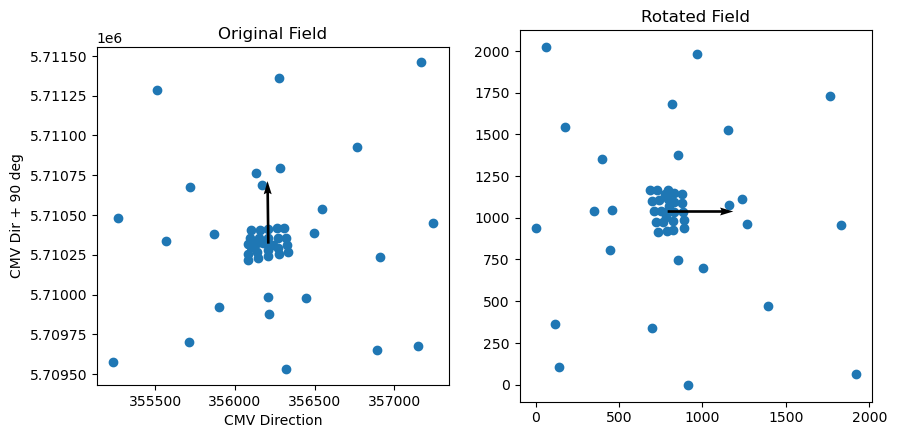

In [4]:
# Rotation by -cld_dir to make CMV align with X Axis
rot = spatial.rotate_vector((pos_utm['E'], pos_utm['N']), theta=-cld_dir)
pos_utm_rot = pd.DataFrame({'X': rot[0] - np.min(rot[0]), 'Y': rot[1] - np.min(rot[1])}, index=pos_utm.index)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(pos_utm['E'], pos_utm['N'])
axs[0].set_title('Original Field')
axs[0].quiver(pos_utm['E'][40], pos_utm['N'][40], 200 * cld_vec_rect[0], 200 * cld_vec_rect[1], scale=10, scale_units='xy')
axs[0].set_xlabel('East')
axs[0].set_ylabel('North')
axs[1].scatter(pos_utm_rot['X'], pos_utm_rot['Y'])
axs[1].quiver(pos_utm_rot['X'][40], pos_utm_rot['Y'][40], 200*cld_spd, 0, scale=10, scale_units='xy')
axs[1].set_title('Rotated Field')
axs[0].set_xlabel('CMV Direction')
axs[0].set_ylabel('CMV Dir + 90 deg')
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')


# Compute Timeseries Statistics
The scaling of the cloud field is based on statistical variability properties of the time series. So we'll extract those in advance. We do so for a single sensor (number 40) that is centrally located in the field. 
- `ktmean` - The mean clearsky index
- `kt1pct` - The 1st percentile of clearsky index, used similar to a minimum
- `ktmax` - The maximum clearsky index (shows cloud enhancement)
- `frac_clear` - Fraction of clear sky conditions in time series (characterized as kt > 0.95)
- `vs` - The variability score of the clearsky index
- `weights` - The weights are calculated from the magnitude-squared of the various wavelet modes contained in the time series. 
- `scales` - The scales of the various wavelet modes contained in the time series.

ktmean:     0.64
kt1pct:     0.38
ktmax:     1.09
frac_clear:     0.12
vs:    25.31


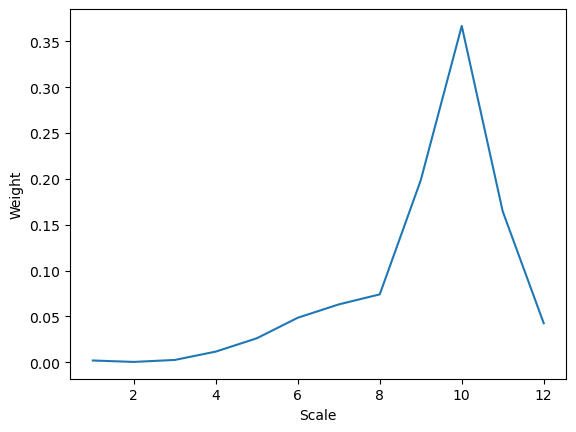

In [7]:
ktmean, kt1pct, ktmax, frac_clear, vs, weights, scales = get_timeseries_stats(kt[40], plot=False)
print(f"ktmean: {ktmean:8.2f}")
print(f"kt1pct: {kt1pct:8.2f}")
print(f"ktmax: {ktmax:8.2f}")
print(f"frac_clear: {frac_clear:8.2f}")
print(f"vs: {vs:8.2f}")

# Plot the wavelet scales
plt.plot(scales, weights)
plt.xlabel('Scale')
plt.ylabel('Weight')
plt.show()

# Relate the Time and Space Scales
Since we rotated the sensor positions, we can now calculate the overall spatial size of the distribution along and perpendicular to the cloud motion vector. We'll also look at the dureation of the time series (in this case 1 hour) and its temporal resolution (1 second). 

Using the cloud speed we can relate these spatial dimensions to time dimensions. When we generate the cloud field, we will assume that each pixel in the field represents a 1-second step in time. So moving 1 pixel within the field along the X axis represents either a 1 second shift upwind or downwind in space, or a 1 second shift of the time axis at a fixed spatial position. Moving 1 pixel along the Y axis will always represent a 1 second shift perpendicular to the cloud motion vector.

In [10]:
x_extent = np.abs(np.max(pos_utm_rot['X']) - np.min(pos_utm_rot['X']))
y_extent = np.abs(np.max(pos_utm_rot['Y']) - np.min(pos_utm_rot['Y']))
t_extent = (np.max(twin) - np.min(twin)).total_seconds()
dt = (twin[1] - twin[0]).total_seconds()

spatial_time_x = x_extent / cld_spd
spatial_time_y = y_extent / cld_spd

xt_size = int(np.ceil(spatial_time_x + t_extent))
yt_size = int(np.ceil(spatial_time_y))

print(f"X Extent: {x_extent:8.2f} m, Y Extent: {y_extent:8.2f} m")
print(f"Time Extent: {t_extent:8.2f} s, Time Resolution: {dt:8.2f} s")
print(f"Field Size: {xt_size}x{yt_size}")


X Extent:  1919.58 m, Y Extent:  2023.44 m
Time Extent:  3600.00 s, Time Resolution:     1.00 s
Field Size: 3698x103


# Generating the Randomized Cloud Field

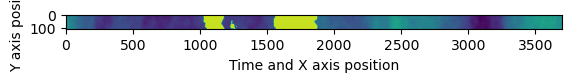

In [17]:
np.random.seed(42)  # Seed for repeatability

field_final = cloudfield_timeseries(weights, scales, (xt_size, yt_size), frac_clear, ktmean, ktmax, kt1pct)

plt.imshow(field_final.T, aspect='equal', cmap='viridis')
plt.xlabel('Time and X axis position')
plt.ylabel('Y axis position')
plt.show()

Internal methodology of the cloud field generation

In [ ]:
from solarspatialtools.synthirrad.cloudfield import _stack_random_field, _calc_clear_mask, _find_edges, _scale_field_lave

internal_size = (xt_size, yt_size)
internal_edgesmoothing = 3
internal_cfield = _stack_random_field(weights, scales, internal_size, plot=False)
internal_clear_mask = _stack_random_field(weights, scales, internal_size)
internal_clear_mask = _calc_clear_mask(internal_clear_mask, frac_clear, plot=False)  # 0 is cloudy, 1 is clear

edges, smoothed = _find_edges(internal_clear_mask, internal_edgesmoothing)

internal_field_final = _scale_field_lave(internal_cfield, internal_clear_mask, smoothed, ktmean, ktmax, kt1pct, plot=False)

Plots about it

In [ ]:
# Plot a timeseries
plt.plot(field_final[:,1:5])

plt.figure()
plt.plot(kt.iloc[:,1:5])
plt.show()

# Convert space to time to extract time series
xpos = pos_utm_rot['X'] - np.min(pos_utm_rot['X'])
ypos = pos_utm_rot['Y'] - np.min(pos_utm_rot['Y'])
xpos_temporal = xpos / cld_spd
ypos_temporal = ypos / cld_spd

sim_kt = pd.DataFrame(index=twin, columns=pos_utm_rot.index)
for sensor in pos_utm_rot.index:
    x = int(xpos_temporal[sensor])
    y = int(ypos_temporal[sensor])
    sim_kt[sensor] = field_final[x:x+int(t_extent)+1, y]

plt.plot(sim_kt[[40,42]])
plt.figure()
plt.plot(kt[[40,42]])
plt.show()




# Compare Hist of CS Index
plt.hist(kt, bins=50)
plt.hist(field_final[:,1], bins=50, alpha=0.5)

# Ramp Rate
plt.figure()
plt.hist(np.diff(kt), bins=50)
plt.hist(np.diff(field_final[:,1]), bins=200, alpha=0.5)
plt.show()
